In [1]:
import os
import sys
import cytopath
import scvelo as scv

import pandas as pd
import numpy as np
np.random.seed(42)

import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import patches as mpatches

from scipy import stats

In [2]:
# Set plotting parameters for scvelo
scv.set_figure_params(style='scvelo', dpi=50, dpi_save=300, frameon=None, vector_friendly=True, 
                                  transparent=True, fontsize=12, figsize=None, color_map=None, facecolor=None, 
                                  format='svg', ipython_format='png2x')

In [3]:
# Cell cycle data comes from Mahdessian et. al. 
# https://doi.org/10.1038/s41586-021-03232-9

# The loom file containing spliced and unsplice counts can be donwload with the link below
# https://drive.google.com/file/d/149ICTtieYjuKWZoLwRLzimwff0n6eWqw/view
#os.system('gdown https://drive.google.com/u/0/uc?id=149ICTtieYjuKWZoLwRLzimwff0n6eWqw&export=download')

# Anndata object used for comparitive analysis
#https://drive.google.com/file/d/1w34zDwiYhHqkiQk6U22LWD-LLOlCCH3Q/view?usp=sharing

adata = scv.read('../cell_cycle/cell_cycle.h5ad')

In [4]:
# Process data and estimate velocity
scv.pp.filter_genes(adata, min_shared_counts=10)
scv.pp.normalize_per_cell(adata)
scv.pp.filter_genes_dispersion(adata, n_top_genes=5000, subset=False)
scv.pp.log1p(adata)

# Computational cell cycle scoring
cytopath.utils.cell_cycle_scores(adata)

# Retain highly variable genes
adata = adata[:, adata.var.highly_variable]

# Smooth counts over neighbors
scv.pp.moments(adata)
scv.tl.velocity(adata)

Filtered out 42710 genes that are detected 10 counts (shared).
Normalized count data: X, spliced, unspliced.
Exctracted 5000 highly variable genes.
computing neighbors
    finished (0:00:05) --> added 
    'distances' and 'connectivities', weighted adjacency matrices (adata.obsp)
computing moments based on connectivities
    finished (0:00:00) --> added 
    'Ms' and 'Mu', moments of un/spliced abundances (adata.layers)
computing velocities
    finished (0:00:00) --> added 
    'velocity', velocity vectors for each individual cell (adata.layers)


In [5]:
# Estimate the cosine similarities between a cell's velocity vector and distance to it's neighbors
scv.tl.velocity_graph(adata, mode_neighbors='connectivities')

# Estimate the transition probability matrix by normalizing the velocity graph excluding self transitions
adata.uns['T_forward'] = scv.utils.get_transition_matrix(adata, self_transitions=False)

computing velocity graph
    finished (0:00:00) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)


In [6]:
# Estimate the terminal states, louvain clustering and velocity embedding
scv.tl.terminal_states(adata)
scv.tl.louvain(adata)
scv.tl.velocity_embedding(adata, basis='umap')

computing terminal states
    identified 1 region of root cells and 1 region of end points .
    finished (0:00:00) --> added
    'root_cells', root cells of Markov diffusion process (adata.obs)
    'end_points', end points of Markov diffusion process (adata.obs)
computing velocity embedding
    finished (0:00:00) --> added
    'velocity_umap', embedded velocity vectors (adata.obsm)


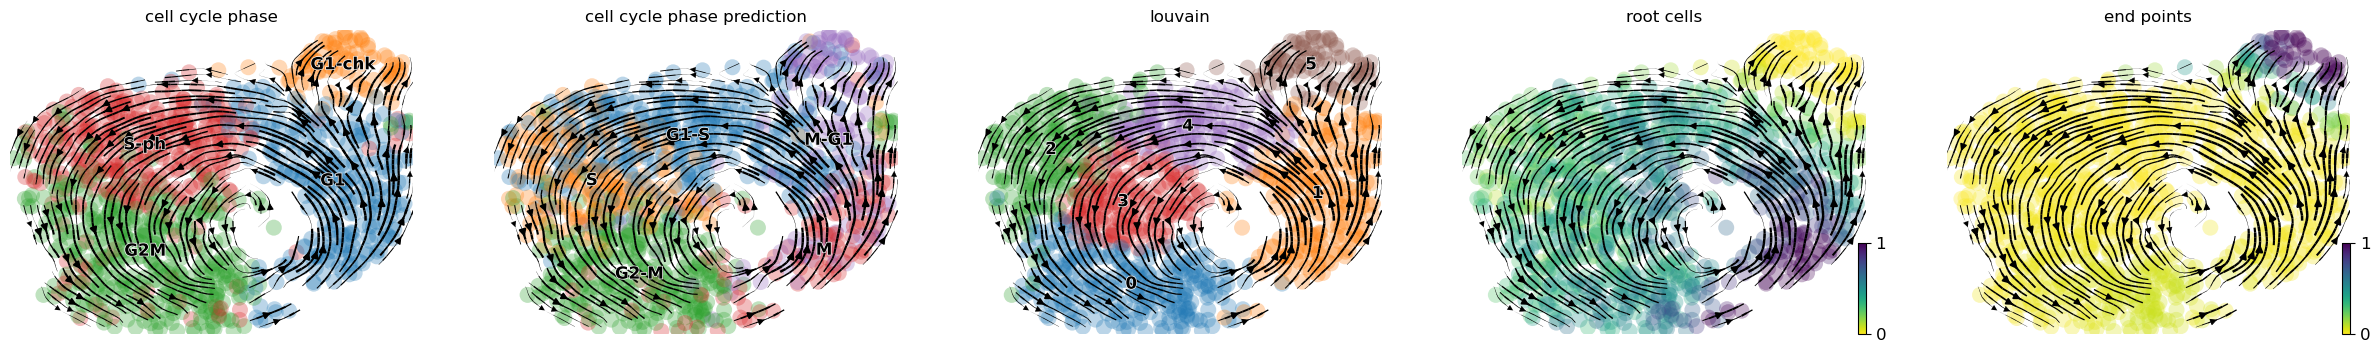

In [7]:
# Cell cycle phase - experimental annotations from Mahdessian et. al. based on flourescence (protein)
# Cell cycle phase prediction - computational annotation based on RNA expression
scv.pl.velocity_embedding_stream(adata, color=['cell_cycle_phase','cell_cycle_phase_prediction',
                                               'louvain', 'root_cells', 'end_points'],
                                             legend_loc='on data')

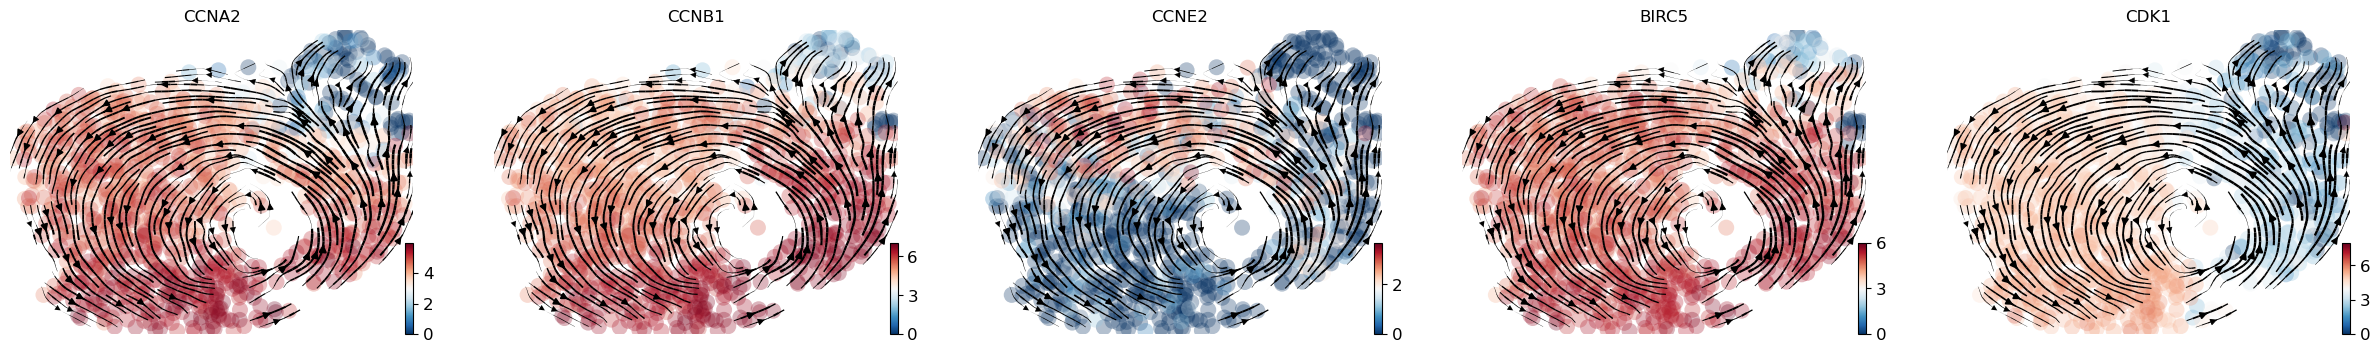

In [8]:
# Project selected markers on UMAP
scv.pl.velocity_embedding_stream(adata, color=['CCNA2', 'CCNB1', 'CCNE2', 'BIRC5', 'CDK1'],
                                             legend_loc='on data')

In [9]:
# Simulate markov chains
cytopath.sampling(adata, num_cores=os.cpu_count()-1)

Adjusting simulation parameters based on dataset properties. Set auto_adjust=False if this is unwanted.
Number of required simulations per end point (traj_number) set to 1515
Number of initial simulations (sim_number) set to 1515
Number of initial simulation steps (max_steps) set to 16

Sampling round: 0


  0%|          | 0/24 [00:00<?, ?it/s]

160.46 % of required simulations obtained for lagging end point 5.
6.6859 % of simulations reached atleast one endpoint. Increasing number of simulation steps to 32.

Sampling round: 1


  0%|          | 0/24 [00:00<?, ?it/s]

Sampling done.


In [10]:
# Infer trajectories
cytopath.trajectories(adata, num_cores=os.cpu_count()-1)

Stage 1 clustering done. Aligning clusters for end point 5
Calculating hausdorff distances


  0%|          | 0/1515 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/7 [00:00<?, ?it/s]

Final clustering done. Aligning clusters for end point 5


  0%|          | 0/7 [00:00<?, ?it/s]

Clustering using hausdorff distances
Forming trajectory by aligning clusters


  0%|          | 0/3 [00:00<?, ?it/s]

Computing neighborhoods of trajectories for end point 5 at each step


  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

Computing alignment score of cells in trajectory neighborhood w.r.t. trajectories for end point  5


  0%|          | 0/308 [00:00<?, ?it/s]

  0%|          | 0/497 [00:00<?, ?it/s]

Removing cells below cutoff threshold from trajectories for end point  5 (i.e. cells neighborhood)


  0%|          | 0/2 [00:00<?, ?it/s]

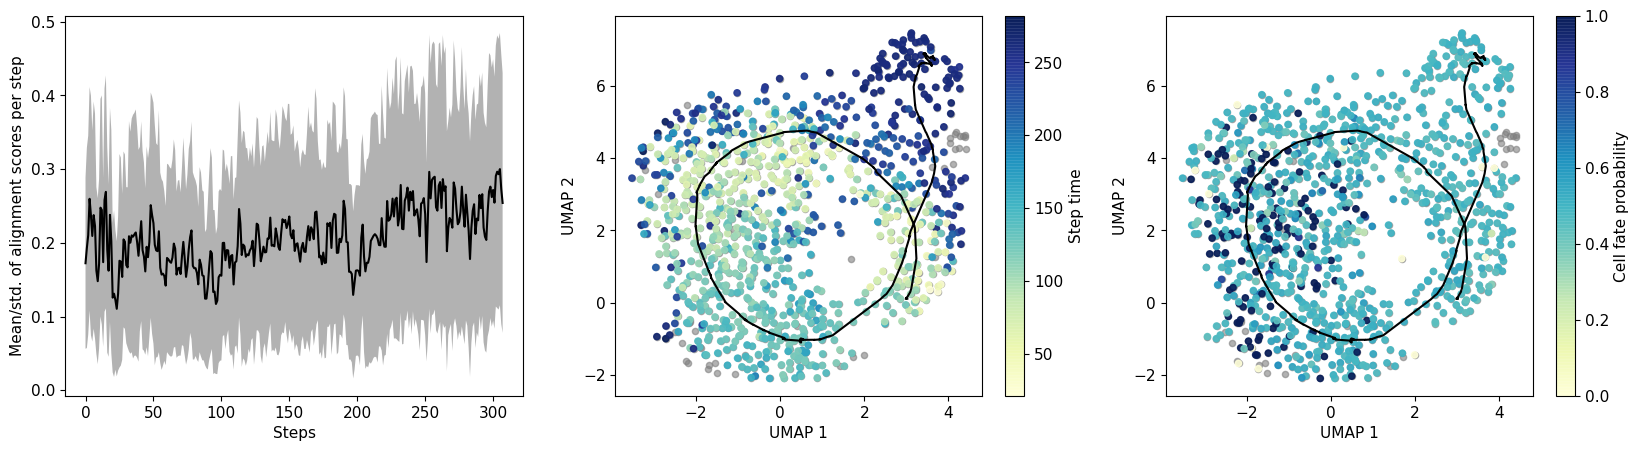

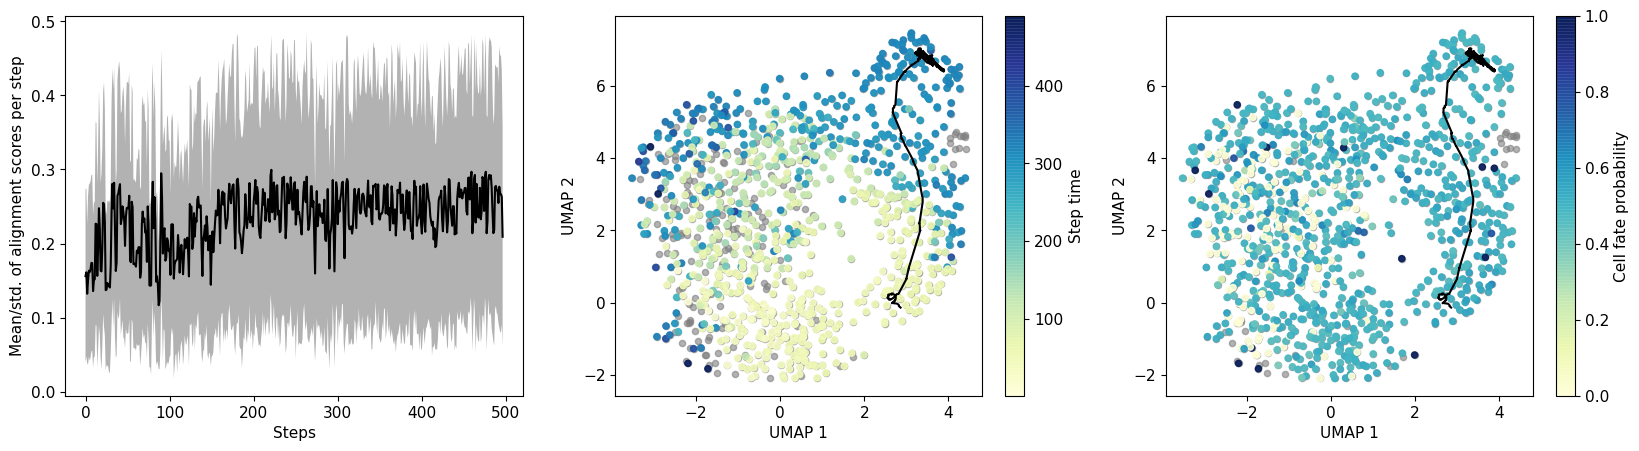

In [11]:
# Plot trajectory and metrics
# Cell fate is redundant in this case since only a single terminal state is present
cytopath.plot_trajectories(adata, figsize=(20,5), size=20, basis='umap')

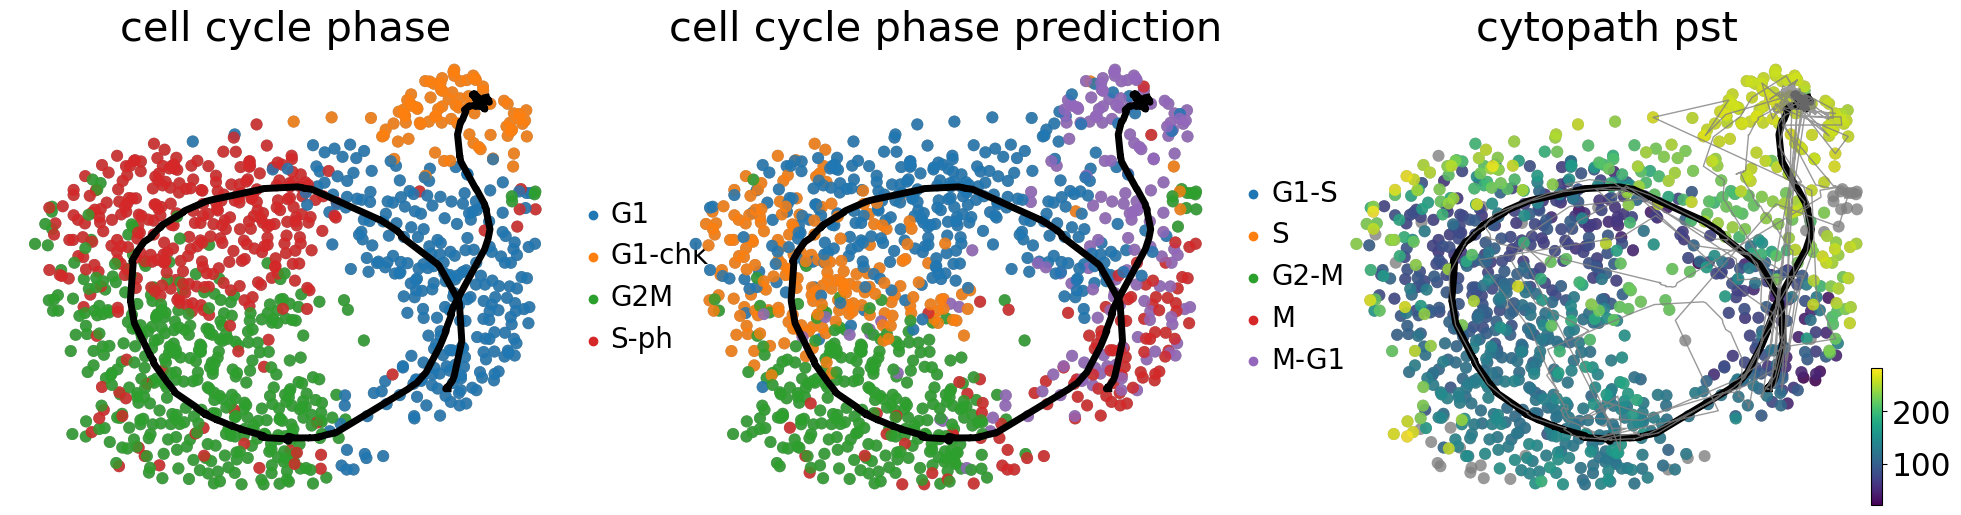

In [12]:
# Plot subtrajectories (first level clustering of simulations)
fig, axs = plt.subplots(ncols=3, figsize=(24,6))

trajectory_num = 0

adata.obs['cytopath_pst'] = adata.uns['trajectories']['step_time'][trajectory_num]
annotation=[('cell_cycle_phase', None), 
            ('cell_cycle_phase_prediction', None), 
            ('cytopath_pst', 'viridis')]

# Plot trajectory and UMAP
for i, ax in enumerate(axs.flat):
    scv.pl.umap(adata, color='grey', size=300, alpha=0.8, ax=ax, show=False)
    scv.pl.umap(adata, color=annotation[i][0], size=300, alpha=0.8, color_map=annotation[i][1],
            legend_loc='right', legend_fontsize=20, fontsize=30, ax=ax, show=False)
    
    traj = np.array(adata.uns['trajectories']['trajectories_coordinates']['5']['trajectory_{}_coordinates'.format(trajectory_num)])
    ax.plot(traj[:,0], traj[:,1], color='black', linewidth=5)
    ax.axis('off')

axs.flat[2].plot(adata.uns['subtrajectories']['subtrajectory_coordinates']['5']['Coordinate_0'], 
            adata.uns['subtrajectories']['subtrajectory_coordinates']['5']['Coordinate_1'], 
            color='grey', alpha=0.8, linewidth=1)
    

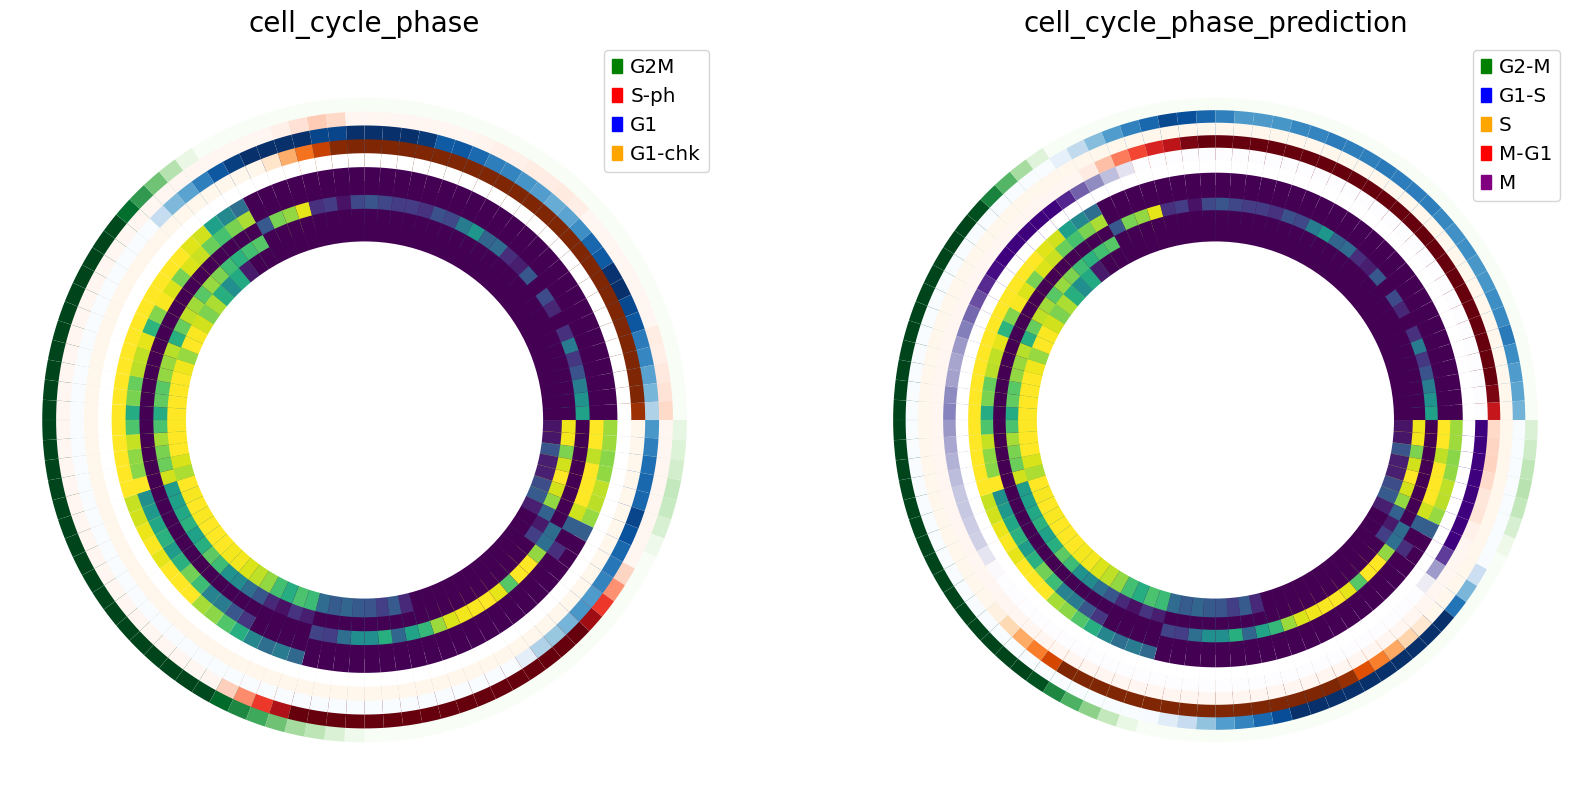

In [13]:
# For a circular trajectory it makes sense to look at each individual alignment of the cell rather than mean
# This data is stored under adata.uns['trajectories']['cells_along_trajectories_each_step']

# Plot clockwise circular heatmaps to see cyclic patterns
fig, axs = plt.subplots(ncols=2, figsize=(20,10))

annotations = [('cell_cycle_phase', ['Greens', 'Reds','Blues','Oranges']),
               ('cell_cycle_phase_prediction', ['Greens', 'Blues','Oranges','Reds', 'Purples'])
               ]

for i, ax in enumerate(axs):
    cytopath.plotting.radial_heatmap(adata, var_names=['CCNA2', 'CCNB1', 'CCNE2', 'BIRC5', 'CDK1'], 
                                     trajectories=trajectory_num, col_color_key=annotations[i][0], 
                                     col_colors=annotations[i][1], ax=ax)
    
    labels = adata.obs[annotations[i][0]].unique()
    patches=[]
    for color in annotations[i][1]:
        patches.append(mpatches.Patch(color=color[:-1]))
    ax.legend(patches, labels, fontsize='large')
    ax.set_title(annotations[i][0], fontsize=20)


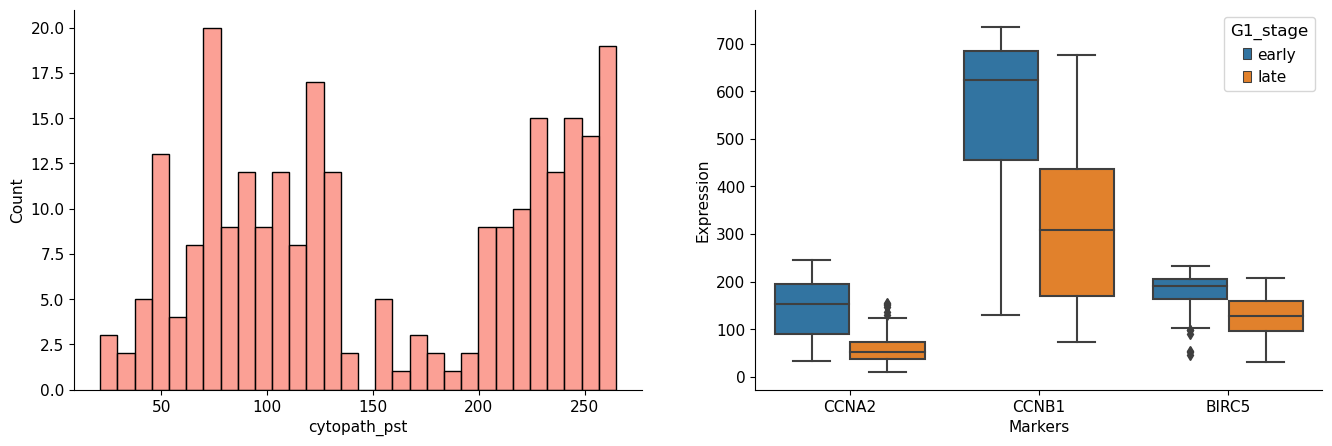

In [14]:
# NOTE: See Mahdessian et. al. for phase-marker correlations 
# phase annotations are experimental and not computational derived from scRNA data
# mRNA concentration of cyclins in G1 is not unexpected in this context

G1_cells = adata.obs.index[adata.obs.cell_cycle_phase=='G1']
adata.obs['G1_groups'] = 'NA'

adata.obs.loc[G1_cells, 'G1_groups'] = 'early'
adata.obs.loc[(adata.obs.cell_cycle_phase == 'G1') & (adata.obs.cytopath_pst > 160), 'G1_groups'] = 'late'

# Expression
data = pd.DataFrame(index=G1_cells, columns= ['G1_stage', 'cytopath_pst', 'CCNA2', 'CCNB1', 'CCNE2', 'BIRC5'])
data['G1_stage'] = adata.obs.loc[G1_cells, ['G1_groups', 'cytopath_pst']].values
data[['CCNA2', 'CCNB1', 'CCNE2', 'BIRC5']] = adata[G1_cells, ['CCNA2', 'CCNB1', 'CCNE2', 'BIRC5']].layers['Ms']

data = data.melt(id_vars='G1_stage', value_vars=['CCNA2', 'CCNB1', 'BIRC5'], var_name='Markers', value_name='Expression')

#Plot
fig, axs = plt.subplots(ncols=2, nrows=1, figsize=(16,5))

# Plot within G1 cluster (even without including G1 checkpoint cluster which has no cyclin expression) 
# Cytopath pseudotime effectively discriminates cells from the same cluster into early and late stage
sns.histplot(adata.obs.loc[adata.obs.cell_cycle_phase=='G1', 'cytopath_pst'], bins=30, color='salmon',ax=axs[0])

sns.boxplot('Markers', 'Expression', hue='G1_stage' , data=data, ax=axs[1])
sns.despine()
